# Dataset: Aceitação de crédito para clientes de um banco australiano

In [1]:
import pandas as pd
import numpy as np

# Caminho do arquivo .dat
file_path = 'australian-ssl20-10-1tra.dat'

# Listas para armazenar as colunas e os dados
columns = []
data = []

# Abrir e processar o arquivo
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Identificar e armazenar atributos
        if line.startswith('@attribute'):
            column_name = line.split()[1]
            columns.append(column_name)
        
        # Identificar e armazenar os dados
        elif not line.startswith('@') and line:  # Ignorar linhas que começam com @ ou estão vazias
            data.append(line.split(','))  # Supondo que os dados estejam separados por vírgula

# Criar o DataFrame
data = pd.DataFrame(data, columns=columns)

# Visualizar o DataFrame
data.head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,1,2675.0,45.0,1,8,5,25.0,0,0,0,0,2,200,1211,0
1,1,3358.0,275.0,2,7,4,425.0,1,1,6,0,2,204,1,1
2,1,2567.0,220.99999999999997,1,6,4,3.9999999999999996,1,0,0,0,2,188,1,0
3,0,2958.0,175.0,1,4,4,125.0,0,0,0,1,2,280,1,0
4,1,2258.0,1004.0,2,14,4,3.9999999999999996,1,1,9,0,2,60,397,1


In [2]:
data.shape

(621, 15)

Entendo quantas instâncias não rotuladas temos

In [3]:
data["Class"].value_counts()

Class
unlabeled    497
0             68
1             56
Name: count, dtype: int64

In [4]:
# Supondo que você já tenha o DataFrame
value_counts = data["Class"].value_counts()

# Calcular porcentagem
percentages = (value_counts / value_counts.sum()) * 100

# Exibir os resultados
result = pd.DataFrame({
    'Class': value_counts.index,
    'Count': value_counts.values,
    'Percentage': percentages.round(2)  # Arredonda para 2 casas decimais
})

result

,Class,Count,Percentage
Class,,,
unlabeled,unlabeled,497,80.03
0,0,68,10.95
1,1,56,9.02


Cerca de 20% das instâncias rotuladas

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A1      621 non-null    object
 1   A2      621 non-null    object
 2   A3      621 non-null    object
 3   A4      621 non-null    object
 4   A5      621 non-null    object
 5   A6      621 non-null    object
 6   A7      621 non-null    object
 7   A8      621 non-null    object
 8   A9      621 non-null    object
 9   A10     621 non-null    object
 10  A11     621 non-null    object
 11  A12     621 non-null    object
 12  A13     621 non-null    object
 13  A14     621 non-null    object
 14  Class   621 non-null    object
dtypes: object(15)
memory usage: 72.9+ KB


Separando em x e y

In [6]:
y = data["Class"]
X = data.drop("Class", axis=1)

Substiuindo "unlabeled" por "-1" para rodar os algoritmos

In [7]:
y = y.replace(" unlabeled", -1).astype(int)
y

0      0
1      1
2      0
3      0
4      1
      ..
616   -1
617   -1
618   -1
619   -1
620   -1
Name: Class, Length: 621, dtype: int64

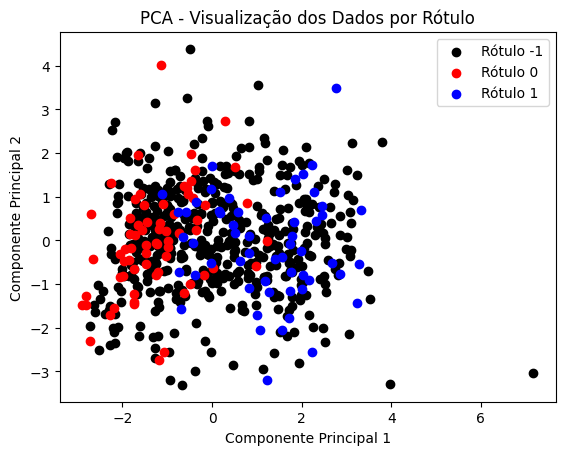

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


scaler = StandardScaler()
pca = PCA(n_components=2)

scaled_data = scaler.fit_transform(X)
reduced_data = pca.fit_transform(scaled_data)

# Criar um novo DataFrame com os dados reduzidos
reduced_df = pd.DataFrame(reduced_data, columns=['Principal Component 1', 'Principal Component 2'])

# Supondo que y tenha três valores únicos, como 0, 1 e 2.
unique_labels = np.unique(y)
colors = ['black', 'red', 'blue']  # Cores para cada rótulo

# Verifique se o número de cores corresponde ao número de rótulos únicos
if len(colors) < len(unique_labels):
    raise ValueError("Não há cores suficientes para representar todos os rótulos.")

# Plotando cada rótulo separadamente
for label, color in zip(unique_labels, colors):
    mask = y == label
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], label=f'Rótulo {label}', color=color)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Visualização dos Dados por Rótulo')
plt.legend()
plt.show()



É possível perceber algumas coisas através desse plot
<ol>
<li>Existe uma fronteira de decisão aparentemente evidente
<li>Os exemplos não rotulados parecem cobrir ambas as classes em proporções levemente diferentes
<li>Existem outliers (poucos)
</ol>

# Modelos indutivos
Aqui tentaremos criar modelos que sejam úteis para a classificação de instâncias futuras da base de dados

# SelfTraining

Separando conjunto de treinamento do conjunto de testes

In [9]:
from sklearn.model_selection import train_test_split
# Filtrar dados rotulados e não rotulados
mask_labeled = y != -1
x_labeled = X[mask_labeled]
y_labeled = y[mask_labeled]

x_unlabeled = X[~mask_labeled]
y_unlabeled = y[~mask_labeled]  # Estas não serão usadas para teste

# Dividir apenas os dados rotulados
x_train, x_test, y_train, y_test = train_test_split(x_labeled, y_labeled, test_size=0.3, random_state=42)

# Reunir instâncias não rotuladas ao conjunto de treinamento
x_train = np.vstack([x_train, x_unlabeled])
y_train = np.concatenate([y_train, y_unlabeled])

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


models = {
    'Decision Tree': DecisionTreeClassifier(),
    "MLP": MLPClassifier()
}

In [11]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score, f1_score

metrics = []
best_model = (None, 0)
for name, model in models.items():

    # Definindo o classificador de self-training
    self_training_model = SelfTrainingClassifier(
        base_estimator=model,
        threshold=0.9,
        max_iter=500
    )    
    # Treinando o classificador de self-training
    self_training_model.fit(x_train, y_train)

    # Fazendo previsões nos dados de teste
    y_pred = self_training_model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    if accuracy > best_model[1]:
        best_model = self_training_model, accuracy

    metrics.append({
            "Modelo": f"SelfTraining({name})",
            "Acurácia": accuracy,
            "F1 Macro": f1_macro,
            "F1 Weighted": f1_weighted
    })
df_metrics = pd.DataFrame(metrics)
df_metrics

/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividades/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividades/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


,Modelo,Acurácia,F1 Macro,F1 Weighted
0,SelfTraining(Decision Tree),0.894737,0.886905,0.897870
1,SelfTraining(MLP),0.631579,0.590769,0.638381


O SelfTraining com árvore de decisão alcançou 86% de acurácia, vamos tentar visualizar a fronteira de decisão aprendida

/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividades/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_40241/728155552.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


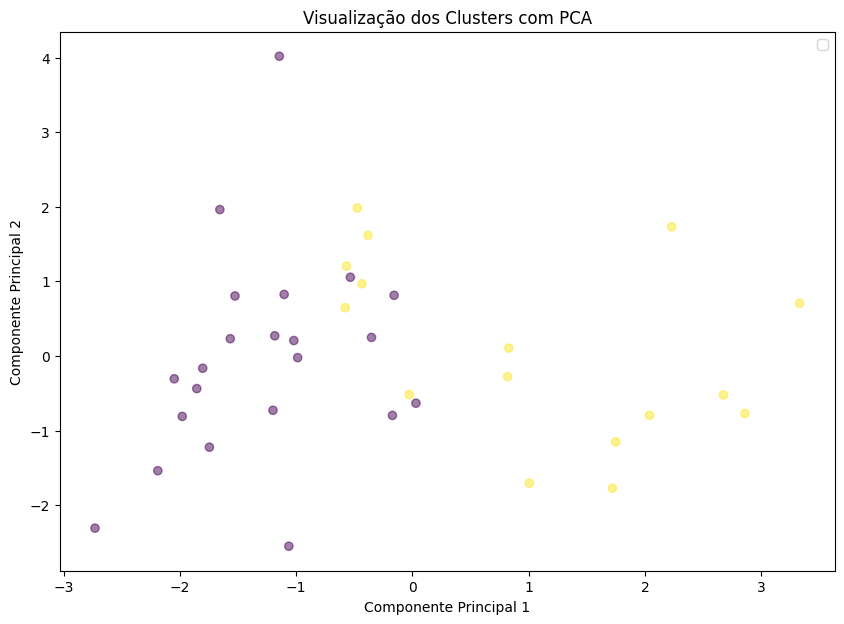

In [12]:
best_self_training_model = best_model[0]
y_pred = best_self_training_model.predict(x_test)

x_test_scaled = scaler.transform(x_test)
data_pca_2 = pca.transform(x_test_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(data_pca_2[:, 0], data_pca_2[:, 1], c=y_pred, cmap='viridis', marker='o', alpha=0.5)
plt.title("Visualização dos Clusters com PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

Pelo menos em duas dimensões, a fronteira aprendida pelo modelo parece fazer sentido visualmente com a imagem vista anteriormente do conjunto de dados completo

# Modelos indutivos
Aqui tentaremos criar modelos para rotular as instâncias não rotuladas da nossa base de dados</br>
<b>Nota:</b> Para termos mais de um modelo transdutivo, tentamos importar alguma implementação do TSVM, mas não eram compatíveis e a única que era, estava repleta de erros 😕. Logo, os modelos transdutivos param por aqui

# Label Propagation

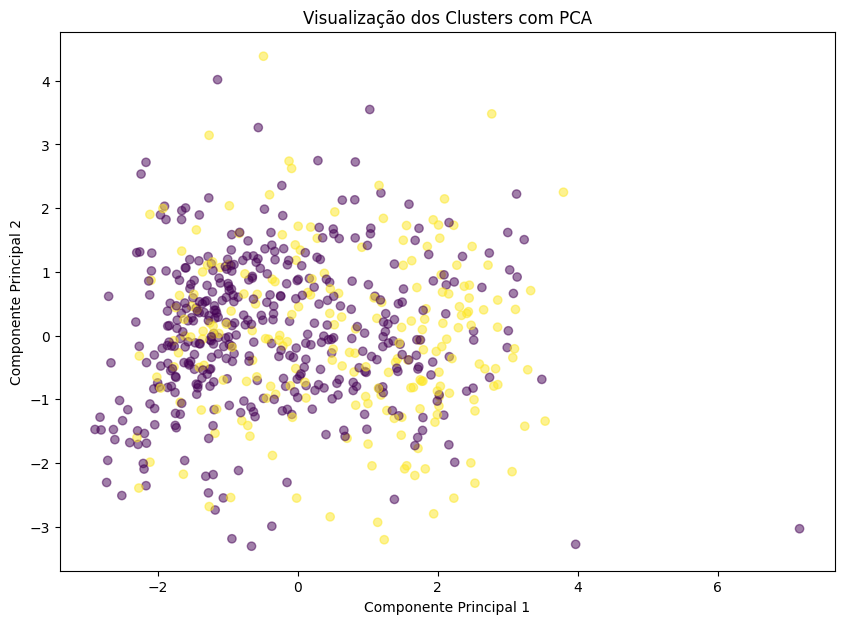

In [18]:
from sklearn.semi_supervised import LabelPropagation

label_propagation_model = LabelPropagation(kernel="knn", n_neighbors=10, max_iter=50000, tol=1e-5, gamma=10)
label_propagation_model.fit(X, y)

labels = label_propagation_model.transduction_

x_test_scaled = scaler.transform(X)
data_pca_2 = pca.transform(x_test_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(data_pca_2[:, 0], data_pca_2[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
plt.title("Visualização dos Clusters com PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

Após o teste de alguns hiper-parâmetros, vamos finalmente aceitar: O label propagation não funcionou muito bem

# Label Spreading

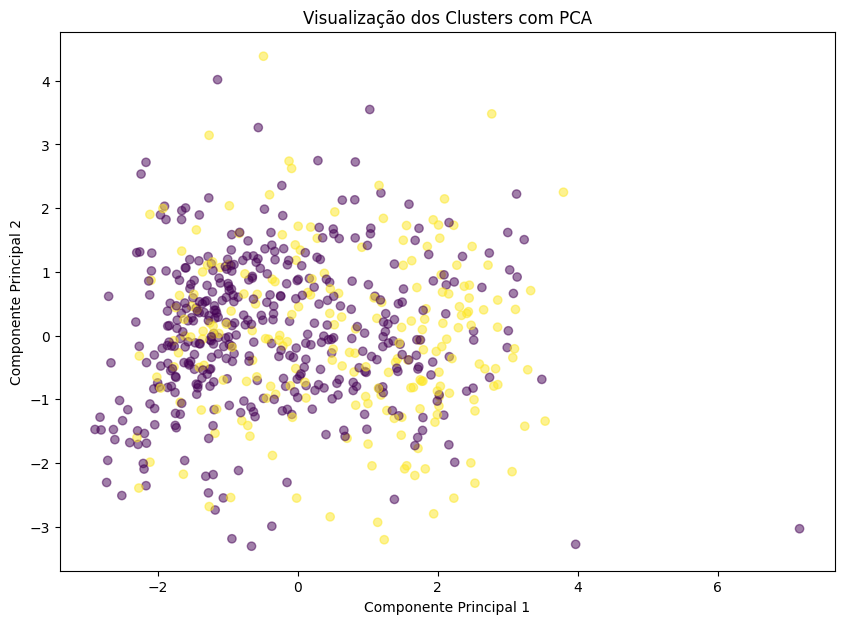

In [20]:
from sklearn.semi_supervised import LabelSpreading

label_spreading_model = LabelSpreading(kernel="rbf", gamma=10, alpha=0.3, max_iter=1000)
label_spreading_model.fit(X,y)

labels = label_propagation_model.transduction_

plt.figure(figsize=(10, 7))
plt.scatter(data_pca_2[:, 0], data_pca_2[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
plt.title("Visualização dos Clusters com PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

Depois de alguns hiper-parâmetros, label-spreading também não conseguiu reconhecer a fronteira de decisão esperada